In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import struct
import skimage.transform
import tensorflow as tf
import datetime
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

# Dependency imports
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from string import ascii_uppercase
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

In [2]:
# cuDNN Model requires numpy version 1.19. Model was built in an AWS environment with that particular version

print(np.__version__)

1.19.2


# Japanese Language Classification

![title_banner](img/title_banner.jpg)

## Agenda

- This project is designed to take image recognition of Japanese characters, and create a learning model that can classify the characters based on the read input.
- Using the three main Japanese language writing systems (Kanji, Hiragana, Katakana), as well as the linguistically depreciated writing system of kuzushiji - used in Japan for over a thousand years since the 8th century.
- The data is from the [ETL Character Database](http://etlcdb.db.aist.go.jp/), which includes over a billion total of Japanese characters hand-written and reorganized by the [National Institute of Advanced Industrial Science and Technology (AIST)](http://www.jeita.or.jp/english/).

### The Writing Systems of Japan

- **Kanji:**
    - Kanji entered Japan in the 8th century via Chinese monks who also brought other traditions with them such as tea and Buddhism. Kanji is based on comparable Chinese characters that convey meaning from pictographic images.<br><br>

- **Hiragana:**
    - Phonetic writing system taking the mostly curviture root aspects of some kanji characters to represent a phonetic representation of sounds. There are 46 individual hiragana characters used today (alongside 29 diphthongs).<br><br>

- **Katakana:**
    - Much like hiragana, katakana is phonetically identical to hiragana. Katakana takes the angular aspects of some kanji characters and is mainly used for foreign words, onamatepeia, and sounds. Katakana contains the same amound of phonetic characters as hiragana.<br><br>

- **Kuzushiji:**
    - A cursive writing style, over 3 million books, on a diverse array of topics such as literature, science, mathematics and cooking written in kuzushiji are preserved today. However, the standardization of Japanese textbooks known as the “Elementary School Order” in 1900, removed Kuzushiji from regular school curriculum, as modern japanese print became popular. As a result, most Japanese natives today cannot read books written or printed in kuzushiji just 120 years ago.

## Data

### Data Information

- Each file contains 5 data sets except ETL8G_33.
- Each data set contains 956 characters written by a writer.
- Each writer wrote 10 sheets (genkouyoushi) per data set.

### Japanese Character Dataset Information

- **Hiragana (ETL 8):**
    - 71 hiragana characters (46 unique + 29 diphthongs)
    - 160 writers
    - 8199 records (genkouyoushi sheets) 
    - 1,254,120,000 unique handwritten hiragana characters (shared with kanji chars in the same files)<br><br>
    
- **Kanji (ETL 8):**
    - 883 daily use kanji
    - 160 writers
    - 8199 records 
    - 152,878,411 unique handwritten kanji (shared with hiragana chars in the same files)<br><br>
    
- **Katakana (ETL 1):**
    - 46 katakana characters (46 unique, dipthongs not included as they are phonetically identical to hiragana)
    - 1411 writers
    - 2052 records
    - 2,436,366 unique handwritten katakana characters

### Import & Read Hiragana

In [3]:
hira_record = 8199

In [ ]:
# Reading the Hiragana ETL8G File

def read_ETL8G(f):
    s = f.read(hira_record)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [ ]:
# Function to read the binary code present in each of the 33 files included in the ETL8G folder

def read_hiragana():
    # Characters = 71, writers = 160, y = 127, x = 128
    hiragana = np.zeros([71, 160, 127, 128], dtype = np.uint8)

    for j in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(5):
                moji = 0
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2] or b'.WO.' in r[2]:
                        if not b'KAI' in r[2] and not b'HEI' in r[2]:
                            hiragana[moji, (j - 1) * 5 + id_dataset] = np.array(r[-1])
                            moji += 1
    np.savez_compressed('data/hiragana.npz', hiragana)

In [ ]:
# Running the Function Above
# read_hiragana()

In [ ]:
hiragana_data = np.load('data/hiragana.npz')
hira_test = hiragana_data.f.arr_0

In [ ]:
hira_test.shape

### Import & Read Kanji

In [4]:
kanji_record = 8199

In [ ]:
def read_kanji():
    # Characters = 883, writers = 160, y = 127, x = 128
    kanji = np.zeros([883, 160, 127, 128], dtype = np.uint8)
    for i in range(1, 33):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed('data/kanji.npz', kanji)

In [ ]:
# read_kanji()

In [ ]:
kanji_data = np.load('data/kanji.npz')
kanji_test = kanji_data.f.arr_0

In [ ]:
kanji_test.shape

### Import & Read Katakana

In [5]:
kana_record = 2052

In [ ]:
# Reading in the Katakana ETL1 File
def read_ETL1(total_sheets, f):
    s = f.read(kana_record)
    r = struct.unpack('>H2sH6BI4H4B4x2016s4x', s)
    iF = Image.frombytes('F', (64, 63), r[18], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

In [ ]:
def read_katakana():
    # Character type = 46, writers = 1411, y = 63, x = 64
    katakana = np.zeros([46, 1411, 63, 64], dtype=np.uint8)
    counter = 0
    moji = 0
    for k in range(7, 14):
        filename = 'data/ETL1/ETL1C_{:02d}'.format(k)
        with open(filename, 'rb') as f:
            total_sheets = 0
            categories = 8
            if k == 13:
                categories = 3
            for j in range(categories):
                incrimenter = 0
                person = 0
                sheets = 1411
                if k == 9 and j == 4:
                    sheets = 1410
                elif k == 12 and j == 1:
                    sheets = 1410
                for i in range(sheets):
                    r = read_ETL1(total_sheets, f)
                    total_sheets += sheets
                    if k < 11 or (k >= 11 and b' I' not in r[1] and b' E' not in r[1] and b'WI' not in r[1] and b' U' not in r[1] and b'WE' not in r[1]):
                        pixels = np.array(r[-1])
                        for row in pixels:
                            for i in range(len(row)):
                                if row[i] == 1 or row[i] == 2:
                                    row[i] = 0
                        katakana[moji, person] = pixels
                        incrimenter = 1
                        person += 1
                moji += incrimenter
    np.savez_compressed('data/katakana.npz', katakana)

In [ ]:
# read_katakana()

In [ ]:
katakana_data = np.load('data/katakana.npz')
kana_test = katakana_data.f.arr_0

In [ ]:
kana_test.shape

## Feature Engineering

- The image dimensions need to be resized for the ML model to work on them. Initially images were resized to 32x32, but due to model performance, they were upsized to be 64x64.

In [11]:
# Image dimensions
img_row, img_col = 64, 64

### Resizing Hiragana Images

In [12]:
# 71 unique classes of hiragana (including dipthongs)
hiragana_class = 71

In [13]:
hiragana_writers = 160

In [26]:
hiragana_table = np.load('data/hiragana.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
hiragana_table = hiragana_table/np.max(hiragana_table)

FileNotFoundError: [Errno 2] No such file or directory: 'data/hiragana.npz'

In [11]:
hiragana_images = np.zeros([hiragana_class * hiragana_writers, img_row, img_col], dtype = np.float32)

for i in range(hiragana_class * hiragana_writers):
    hiragana_images[i] = skimage.transform.resize(hiragana_table[i], (img_row, img_col))

In [12]:
hiragana_images.shape

(11360, 64, 64)

### Resizing Kanji Images

In [14]:
# 879 unique classes of kanji (most daily used kanji)
kanji_class = 873

In [15]:
kanji_writers = 160

In [5]:
kanji_table = np.load('data/kanji.npz')['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
kanji_table = kanji_table/np.max(kanji_table)

- The kanji and hiragana characters share the ECT8 dataset, and they are not intuitively arranged. This accounts for this so hiragana are not mistakenly classified as kanji characters.

In [6]:
kanji_images = np.zeros([kanji_class * kanji_writers, img_row, img_col], dtype = np.float32)

for i in range((kanji_class + 4) * kanji_writers):
    if int(i / 160) != 88 and int( i / kanji_writers) != 219 and int( i / kanji_writers) != 349 and int( i / kanji_writers) != 457:
        if int(i / kanji_writers) < 88:
            kanji_images[i] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i / kanji_writers) > 88 and int(i / kanji_writers) < 219:
            kanji_images[i - kanji_writers] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i / kanji_writers) > 219 and int(i / kanji_writers) < 349:
            kanji_images[i - (kanji_writers * 2)] = skimage.transform.resize(kanji_table[i], (img_row, img_col))
        if int(i / kanji_writers) > 349 and int(i/160) < 457:
            if int(i / kanji_writers) > 457:
                kanji_images[i - (kanji_writers * 4)] = skimage.transform.resize(kanji_table[i], (img_row, img_col))

In [7]:
kanji_images.shape

(139680, 64, 64)

### Resizing Katakana Images

In [16]:
# 71 frequently used katakana characters (including dipthongs)
katakana_class = 46

In [17]:
katakana_writers = 1411

In [15]:
katakana_table = np.load('data/katakana.npz')['arr_0'].reshape([-1, 63, 64]).astype(np.float32)
katakana_table = katakana_table/np.max(katakana_table)

In [16]:
katakana_images = np.zeros([katakana_class * katakana_writers, img_row, img_col], dtype = np.float32)

for i in range(katakana_class * katakana_writers):
    katakana_images[i] = skimage.transform.resize(katakana_table[i], (img_row, img_col))

In [17]:
katakana_images.shape

(64906, 64, 64)

## EDA

In [9]:
# Character counts from the extraction performed above

hiragana_chars = 11360
kanji_chars = 139680
katakana_chars = 64906

In [22]:
# Creating a dataframe to get an idea of global variable distribution

japan = pd.DataFrame([['Hiragana', hira_record, hiragana_chars, hiragana_class, hiragana_writers],
                     ['Katakana', kana_record, katakana_chars, katakana_class, katakana_writers],
                     ['Kanji', kanji_record, kanji_chars, kanji_class, kanji_writers]],
               columns = ['Writing System', 'Records', 'Characters', 'Classes', 'Writers'])
japan

,Writing System,Records,Characters,Classes,Writers
0,Hiragana,8199,11360,71,160
1,Katakana,2052,64906,46,1411
2,Kanji,8199,139680,873,160


### Number of Records in Dataset

''

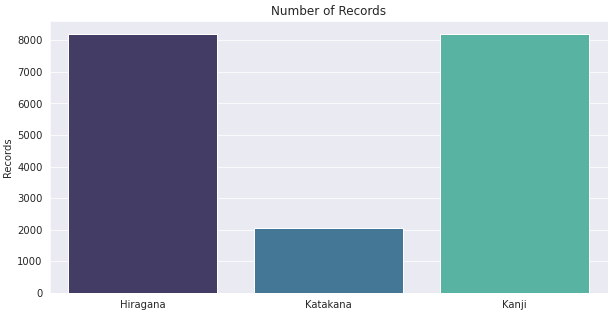

In [74]:
record_data = {'Hiragana': hira_record, 'Katakana': kana_record, 'Kanji': kanji_record}
record_names = list(record_data.keys())
record_values = list(record_data.values())

with sns.axes_style("darkgrid"):
    plt.figure(figsize = (10, 5))
    plt.title('Number of Records')
    plt.ylabel('Records')
    sns.barplot(x = record_names, y = record_values, palette = 'mako')
    # plt.savefig('img/records.png')
;

### Distribution of Character Data

''

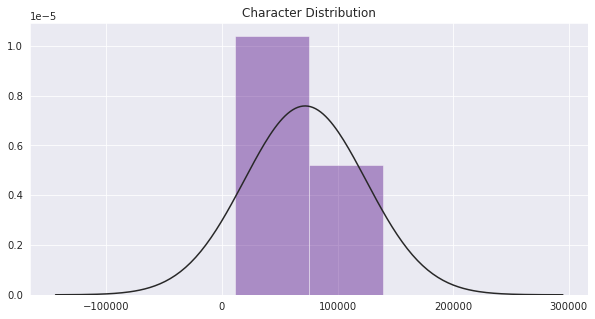

In [72]:
char_data = {'Hiragana': hiragana_chars, 'Katakana': katakana_chars, 'Kanji': kanji_chars}
char_names = list(char_data.keys())
char_values = list(char_data.values())

with sns.axes_style("darkgrid"):
    plt.figure(figsize = (10, 5))
    plt.title('Character Distribution')
    sns.distplot(x = char_values, fit = norm, kde = False, color = 'indigo')
;

### Character Amounts in Each Writing System

''

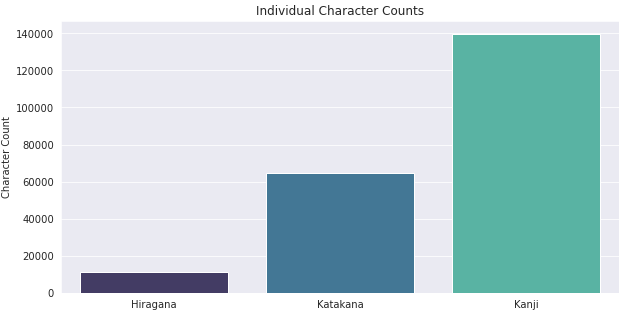

In [75]:
char_data = {'Hiragana': hiragana_chars, 'Katakana': katakana_chars, 'Kanji': kanji_chars}
char_names = list(char_data.keys())
char_values = list(char_data.values())

with sns.axes_style("darkgrid"):
    plt.figure(figsize = (10, 5))
    plt.title('Individual Character Counts')
    plt.ylabel('Character Count')
    sns.barplot(x = char_names, y = char_values, palette = 'mako') 
    # plt.savefig('img/chars.png')
;

### Writers of Each System

''

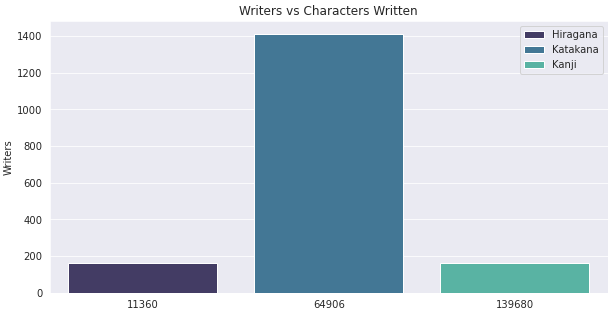

In [96]:
writer_data = {'Hiragana': hiragana_writers, 'Katakana': katakana_writers, 'Kanji': kanji_writers}
writer_names = list(writer_data.keys())
writer_values = list(writer_data.values())

with sns.axes_style("darkgrid"):
    plt.figure(figsize = (10, 5))
    plt.title('Writers vs Characters Written')
    plt.ylabel('Writers')
    sns.barplot(x = char_values, y = writer_values, palette = 'mako', hue = writer_names, dodge = False) 
    # plt.savefig('img/writers.png')
;

### Class Imbalance

''

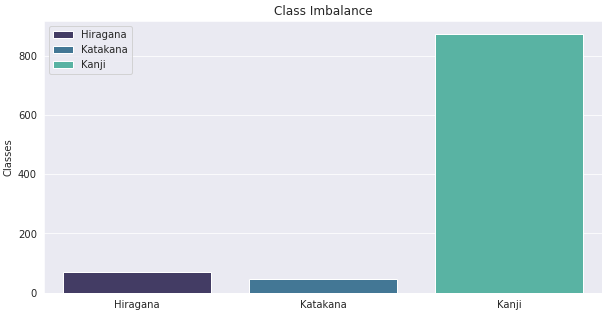

In [99]:
class_data = {'Hiragana': hiragana_class, 'Katakana': katakana_class, 'Kanji': kanji_class}
class_names = list(class_data.keys())
class_values = list(class_data.values())

with sns.axes_style("darkgrid"):
    plt.figure(figsize = (10, 5))
    plt.title('Class Imbalance')
    plt.ylabel('Classes')
    sns.barplot(x = class_names, y = class_values, palette = 'mako', hue = class_names, dodge = False) 
    # plt.savefig('img/class_imb.png')
;

### Visualizing Characters

#### Visualizing Hiragana

In [100]:
# Visualizing Hiragana
def visualize_hiragana():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if b'.HIRA' in r[2]:
                        print(r[:4])

In [101]:
visualize_hiragana()

FileNotFoundError: [Errno 2] No such file or directory: 'data/ETL8G/ETL8G_01'

In [ ]:
def one_kana():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if b'.WO.' in r[2]:
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'img/kana_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [ ]:
one_kana()

- Kana Sample Visualization ![kana](img/kana_visualization.png)

#### Visualizing Kanji

In [ ]:
def visualize_kanji():
    for j in range(1, 2):
        filename = 'data/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(1):
                new_img = Image.new('L', (128*32, 128*30))
                for i in range(956):
                    r = read_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                        print(r[:4])

In [ ]:
visualize_kanji()

In [ ]:
def one_kanji():
    filename = 'data/ETL8G/ETL8G_01'
    counter = 0
    with open(filename, 'rb') as f:
        for id_dataset in range(5):
            for i in range(956):
                r = read_ETL8G(f)
                if not (b'.HIRA' in r[2] or b'.WO.' in r[2]):
                    iE = Image.eval(r[-1], lambda x: 255-x*16)
                    fn = 'img/kanji_visualization.png'.format((r[0]-1)%20+1, hex(r[1])[-4:])
                    # iE.save(fn, 'PNG')

In [ ]:
one_kanji()

- Kanji Sample Visualization: ![kanji](img/kanji_visualization.png)

## Model Preparation

### Creating Labels

- Creating labels for multiclass classification for the three writing systems and merged datasets of them.

In [18]:
# Three classification types

y_labels_hiragana = np.zeros(hiragana_images.shape[0]) + 0
y_labels_kanji = np.zeros(kanji_images.shape[0]) + 1
y_labels_katakana = np.zeros(katakana_images.shape[0]) + 2

#### Merging Labels

In [19]:
merged_labels = np.concatenate([y_labels_hiragana, y_labels_kanji, y_labels_katakana])

In [20]:
# np.savez_compressed('data/merged_labels.npz', merged_labels)

In [21]:
merged_labels.shape

(215946,)

### Merging Dataset Images

In [22]:
merged_images = np.vstack([hiragana_images, kanji_images, katakana_images])
# np.savez_compressed('data/merged_images.npz', merged_images)

In [23]:
merged_images.shape

(215946, 64, 64)

### Train-Test Split

#### Merged Train-Test Split

In [6]:
final_images = np.load('data/merged_images.npz')['arr_0']
final_labels = np.load('data/merged_labels.npz')['arr_0']

In [7]:
japanese_train, japanese_test, japanese_labels, japanese_test_labels = train_test_split(
                                                    final_images,
                                                    final_labels,
                                                    random_state=42,
                                                    test_size=0.2)

#### Creating Validation Set

- For classification of multiple input types and target variables, we need to create a cross-validation set as well as OneHotEncode our y values (y_train, y_val (validation set), y_test (labels)
- We will divide our X values by the number of classes to normalize our pixel values to be between 0 & 1

In [8]:
X_train, X_val, y_train, y_val =\
    train_test_split(japanese_train, japanese_labels, random_state = 42, test_size = 0.2)

X_train, X_val, X_test = X_train/np.max(X_train), X_val/np.max(X_val),\
                                        japanese_test/np.max(japanese_test)

In [9]:
# One Hot Encode our y values. Fit & transform on y train and only transform on our CV and test data.

japanese_ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
y_train = japanese_ohe.fit_transform(y_train.reshape(-1, 1))
y_val = japanese_ohe.transform(y_val.reshape(-1, 1))
y_test = japanese_ohe.transform(japanese_test_labels.reshape(-1, 1))

In [28]:
y_val.shape

(34552, 3)

In [29]:
y_train.shape

(138204, 3)

In [30]:
y_test.shape

(43190, 3)

In [31]:
X_test.shape

(43190, 64, 64)

#### Saving the Final Image Data

In [ ]:
# np.savez_compressed('data/japanese_X_train.npz', X_train)
# np.savez_compressed('data/japanese_X_validation.npz', X_val)
# np.savez_compressed('data/japanese_X_test.npz', X_test)
# np.savez_compressed('data/japanese_y_train.npz', y_train)
# np.savez_compressed('data/japanese_y_validation.npz', y_val)
# np.savez_compressed('data/japanese_y_test.npz', y_test)

## Visualization Tables

- Checking that our finalized data was extracted and correctly, and is readable in the correct visual format.

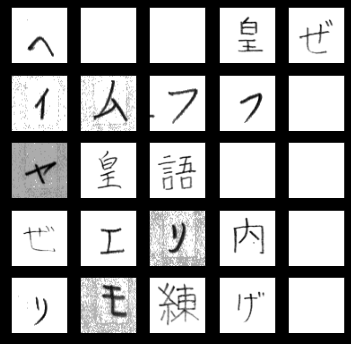

In [81]:
plt.figure(figsize = (6, 6)).patch.set_facecolor('black')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(japanese_train[i], cmap = plt.cm.binary)
# plt.savefig('img/merged_images.png')
plt.show();

## Model Evaluation & Results

### Shallow Algorithms

In [32]:
# Adjusting image dimensions for shallow algorithm results. 
# This was done to training & validation data on KNN & Random Forest Notebooks.

test_samples, test_sample_X, test_sample_y = X_test.shape
shallow_X_test = X_test.reshape((test_samples, test_sample_X * test_sample_y))

#### KNN Model Results

In [33]:
knn_infile = open('models/knn.pickle', 'rb')
knn_model = pickle.load(knn_infile)
knn_infile.close()

In [35]:
knn_y_pred = knn_model.predict(shallow_X_test)

In [44]:
knn_acc = accuracy_score(y_test, knn_y_pred)
knn_prec = precision_score(y_test, knn_y_pred, average = 'micro')
knn_rec = recall_score(y_test, knn_y_pred, average = 'micro')
knn_f1 = f1_score(y_test, knn_y_pred, average = 'micro')

shallow_results = pd.DataFrame([['KNN', knn_acc, knn_prec, knn_rec, knn_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
shallow_results

,Model,Accuracy,Precision,Recall,F1 Score
0,KNN,0.959528,0.966848,0.959528,0.963174


#### Random Forest Model Results

In [45]:
rf_infile = open('models/random_forest.pickle', 'rb')
rf_model = pickle.load(rf_infile)
rf_infile.close()

In [46]:
rf_y_pred = rf_model.predict(shallow_X_test)

In [47]:
rf_acc = accuracy_score(y_test, rf_y_pred)
rf_prec = precision_score(y_test, rf_y_pred, average = 'micro')
rf_rec = recall_score(y_test, rf_y_pred, average = 'micro')
rf_f1 = f1_score(y_test, rf_y_pred, average = 'micro')

rf_metrics = pd.DataFrame([['Random Forest', rf_acc, rf_prec, rf_rec, rf_f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
shallow_results = shallow_results.append(rf_metrics, ignore_index = True)
shallow_results

,Model,Accuracy,Precision,Recall,F1 Score
0,KNN,0.959528,0.966848,0.959528,0.963174
1,Random Forest,0.949572,0.963469,0.949572,0.956470


### Deep Learning Models

#### CNN Model Results

In [46]:
# Loading/importing the CNN model trained on the 'cnn_model notebook'

cnn_model = tf.keras.models.load_model('models/cnn_model.h5')

In [85]:
# Reshaping test set. Default shape for CNN is 'channels_last', this makes sure everything is in the right order

if K.image_data_format() == 'channels_first':
    cnn_X_test = X_test.reshape(X_test.shape[0], 1, img_row, img_col)
else:
    cnn_X_test = X_test.reshape(X_test.shape[0], img_row, img_col, 1)

''

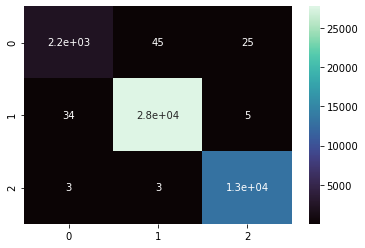

In [74]:
cnn_y_hat_test = np.argmax(cnn_model.predict(cnn_X_test), axis = -1)
cnn_test_restore = japanese_ohe.inverse_transform(y_test)
cnn_matrix = confusion_matrix(cnn_test_restore, cnn_y_hat_test)

sns.heatmap(cnn_matrix, cmap = 'mako', annot = True)
# plt.savefig('img/cnn_model_cm.png')
;

In [58]:
# cnn_test_loss, cnn_test_acc = cnn_model.evaluate(cnn_X_test, y_test)

1350/1350 [==============================] - 38s 28ms/step - loss: 0.0090 - accuracy: 0.9973


In [59]:
print(f'We acheived a test accuracy of {round(cnn_test_acc, 4)}% on our CNN model for our Japanese dataset.')

We acheived a test accuracy of 0.9973% on our CNN model for our Japanese dataset.


#### cuDNN Model Results

In [3]:
# Loading/importing the cuDNN model trained on the 'cuDNN_model notebook'
# This model required downgrading numpy to version 1.19.2 and hence was done in a separate environment in the cloud

cudnn_model = tf.keras.models.load_model('models/cudnn_model.h5')

''

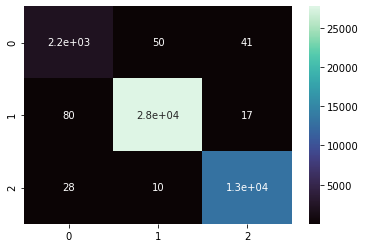

In [23]:
cudnn_y_hat_test = np.argmax(cudnn_model.predict(X_test), axis = -1)
cudnn_test_restore = japanese_ohe.inverse_transform(y_test)
cudnn_matrix = confusion_matrix(cudnn_test_restore, cudnn_y_hat_test)

sns.heatmap(cudnn_matrix, cmap = 'mako', annot = True)
plt.savefig('img/cudnn_model_cm.png')
;

In [25]:
cudnn_test_loss, cudnn_test_acc = cudnn_model.evaluate(X_test, y_test)

1350/1350 [==============================] - 49s 36ms/step - loss: 0.0199 - accuracy: 0.9948


In [26]:
print(f'We acheived a test accuracy of {round(cudnn_test_acc, 4)}% on our cuDNN model for our Japanese dataset.')

We acheived a test accuracy of 0.9948% on our cuDNN model for our Japanese dataset.


## Conclusions & Next Steps

### Conclusions:

- As anticipated, the shallow algorithm models did a good job with predictions, but the GPU-run deep learning models were clear over-acheivers
- Over 200,000 japanese images were trained to 99% Accuracy
- Hiragana and Katakana descend from the curved and angled root aspects of kanji, respectively. These roots may have had a part in helping the model recognize characters that share these roots, as well as the radicals that also encompass kanji
- The complexity of kanji and the simple forms of kana (hiragana & katakana) could have created a mutual assistance that helped the model differentiate the classes.

### Next Steps:

- Work with kuzushiji (Japanese cursive writing) KMINST dataset variations. Notoriusly difficult to read and decipher, this would create a challenge where individuals' handwriting and calligraphy styles may come into play
- OpenCV for live model image recognition using webcam, video, or image uploads.
- Expand model for touchscreen API integration for language education (iOS app) using the trained individual models from previous [kana recognition model project](https://github.com/Mynusjanai/kana_recognition)
- The CUNY Endangered Language Initiative strives to preserve our dying languages around the world. Use model as a way to utilize computational linguistics and preserve precious texts and early written Japanese history